# Imporant pixels

You are given a pipeline that trains a fully convolutional autoencoder on the MNIST dataset. The model should train in under 2 minutes and give decent results (mean reconstruction loss <35).

Your task is to write a function that for a given input image and output pixel coordinates produces a list of input pixels that have non-zero contribution to the value of the output pixel. You should measure each pixel's contribution by setting it to the minimal and maximal value over the whole image.


Training pipeline (DO NOT CHANGE THIS SECTION)

In [1]:
import typing
import os
import random
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [2]:
epochs = 5
batch_size = 250
learning_rate = 1e-2
log_interval = 40

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Binarize:
    def __call__(self, sample):
        return torch.bernoulli(sample)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    Binarize(),
    transforms.Normalize([0.5], [0.5])
])

train = MNIST('./data', train=True, transform=img_transform, download=True)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = MNIST('./data', train=False, transform=img_transform, download=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [4]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(
            1,
            16,
            kernel_size=(3, 3),
            padding=1,
            stride=1,
            bias=False,
        ),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Conv2d(
            16,
            32,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Conv2d(
            32,
            64,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                64,
                32,
                7,
                2,
                0,
                bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                32,
                16,
                3,
                1,
                0,
                bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                16,
                8,
                5,
                1,
                0,
                bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                8,
                1,
                4,
                1,
                0,
                bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data, reduction="sum")
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / data.size(0)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, data, reduction='sum').item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))



In [6]:
model = FCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 1198.477875
Train Epoch: 1 [10000/60000 (17%)]	Loss: 197.618031
Train Epoch: 1 [20000/60000 (33%)]	Loss: 150.052188
Train Epoch: 1 [30000/60000 (50%)]	Loss: 124.459656
Train Epoch: 1 [40000/60000 (67%)]	Loss: 104.739406
Train Epoch: 1 [50000/60000 (83%)]	Loss: 96.466688

Test set: Average loss: 84.9933

Train Epoch: 2 [0/60000 (0%)]	Loss: 86.395422
Train Epoch: 2 [10000/60000 (17%)]	Loss: 79.072484
Train Epoch: 2 [20000/60000 (33%)]	Loss: 78.852844
Train Epoch: 2 [30000/60000 (50%)]	Loss: 72.142047
Train Epoch: 2 [40000/60000 (67%)]	Loss: 64.542754
Train Epoch: 2 [50000/60000 (83%)]	Loss: 71.019969

Test set: Average loss: 62.1662

Train Epoch: 3 [0/60000 (0%)]	Loss: 61.336977
Train Epoch: 3 [10000/60000 (17%)]	Loss: 56.794031
Train Epoch: 3 [20000/60000 (33%)]	Loss: 56.497602
Train Epoch: 3 [30000/60000 (50%)]	Loss: 54.881977
Train Epoch: 3 [40000/60000 (67%)]	Loss: 58.449676
Train Epoch: 3 [50000/60000 (83%)]	Loss: 48.533969

Test set: Average loss

# Important pixels

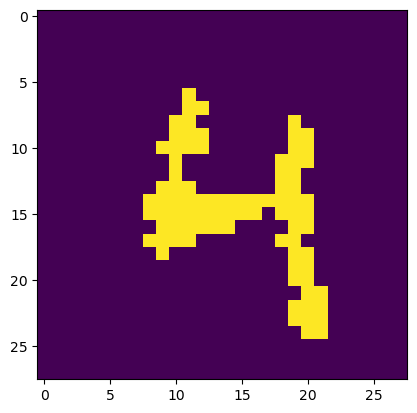

In [7]:
input_batch = next(iter(train_loader))[0][0,:].unsqueeze(0)
input_batch = input_batch.to(device)
plt.imshow(input_batch[0, :].cpu().detach().squeeze().numpy())

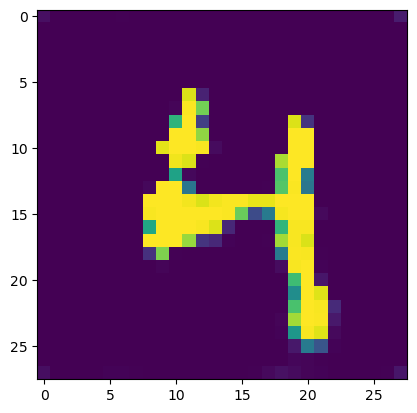

In [8]:
plt.imshow(model(input_batch)[0, :].cpu().detach().squeeze().numpy())

In [20]:
def important_pixels(input_batch: torch.Tensor, model: torch.nn.Module, device: torch.device, coordinates: typing.Tuple[int, int]) -> typing.List[typing.Tuple[int,int]]:
    model = model.to(device)
    input_batch = input_batch.to(device)
    
    _, _, h, w = input_batch.shape
    input_im = input_batch.clone().reshape(h, w)

    min_val = torch.min(input_im)
    max_val = torch.max(input_im)

    images_min = []
    images_max = []


    for y in range(h):
        for x in range(w):
            img_min = input_im.clone()
            img_min[y, x] = min_val
            images_min.append(img_min)
            
            img_max = input_im.clone()
            img_max[y, x] = max_val
            images_max.append(img_max)
    
    batch_min = torch.stack(images_min).reshape(h*w, 1, h, w)
    batch_max = torch.stack(images_max).reshape(h*w, 1, h, w)

    with torch.no_grad():
        output_min = model(batch_min)
        output_max = model(batch_max)

    y_or, x_or = coordinates
    
    vals_min = output_min[:, 0, y_or, x_or]
    vals_max = output_max[:, 0, y_or, x_or]

    eps = 1e-1
    
    diff = torch.abs(vals_max - vals_min)

    important_indices = torch.nonzero(diff > eps, as_tuple=False).flatten().tolist()

    result = []
    for n in important_indices:
        y = n // w
        x = n % w
        
        result.append((y, x))

    return result

In [21]:
checked_pixel = (15, 15)
pixels = important_pixels(input_batch, model, device, checked_pixel)

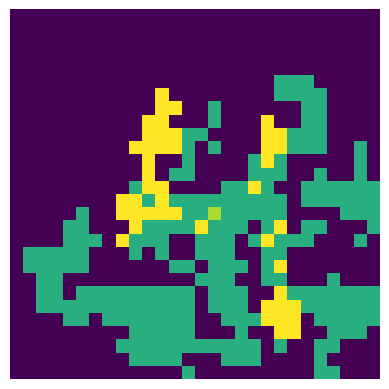

In [22]:
input_image_numpy = input_batch[0, :].cpu().detach().squeeze().numpy()

for pixel in pixels:
    input_image_numpy[pixel[0], pixel[1]] = 0.25

input_image_numpy[checked_pixel[0], checked_pixel[1]] = 0.75

plt.imshow(input_image_numpy)
plt.axis("off")
plt.show()